# Diversity Evolutionary Algorithm

In [1]:
from functools import partial

import numpy as np

from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel.ec.a004 import (
    EA,
    EASettings,
    EAStep,
    Individual,
    Population,
    parent_selection,
)
from ariel.ec.genotypes.nde.nde import NeuralDevelopmentalEncoding
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.characterize.population import (
    get_full_analyzed_population,
    matrix_derive_neighbourhood,
)

#from examples.z_ec_course.A3_template import NUM_OF_MODULES


NUM_OF_MODULES = 20
SEED = 42
RNG = np.random.default_rng(SEED)

In [2]:
from ariel_experiments.gui_vis.view_mujoco import view

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#################################
global_fitness_history = []

In [4]:
def float_creep(
    individual: list[list[float]] | list[list[list[float]]],
    mutation_probability: float,
) -> list[list[float]]:
    # Prep
    ind_arr = np.array(individual)
    shape = ind_arr.shape

    # Generate mutation values
    mutator = RNG.uniform(
        size=shape,
    )

    # Include negative mutations
    sub_mask = RNG.choice(
        [-1, 1],
        size=shape,
    )

    # Determine which positions to mutate
    do_mask = RNG.choice(
        [1, 0],
        size=shape,
        p=[mutation_probability, 1 - mutation_probability],
    )
    mutation_mask = mutator * sub_mask * do_mask
    new_genotype = ind_arr + mutation_mask
    return new_genotype.tolist()

In [5]:
##################################
def record_mean_fitness(population: Population) -> Population:
    if population and hasattr(population[0], 'fitness'):
        mean_fitness = np.mean([ind.fitness for ind in population if hasattr(ind, 'fitness')])
        global_fitness_history.append(mean_fitness)
        print(f"Generation {len(global_fitness_history)} - Mean fitness: {mean_fitness:.4f}")
    return population

# Settings

In [6]:
# EA settings
config = EASettings()
config.is_maximisation = False
config.num_of_generations = 30
config.target_population_size = 1000 # this is the starting population
DELTA_POP = ((config.target_population_size-50)/(config.num_of_generations)) # population we go towards is 50

# evaluation settings
similarity_config = ctk.create_similarity_config(
    radius_strategy=ctk.RadiusStrategy.TREE_GLOBAL,
    weighting_mode=ctk.WeightingMode.LINEAR,
    max_tree_radius=3,
    missing_data_mode=ctk.MissingDataMode.TREAT_AS_ZERO,
    tanimoto_mode=ctk.TanimotoMode.COUNTS,
    softmax_beta=1,
    power_mean_p=2,
)


# EA functions

In [7]:
def make_random_robot(genotype_size: int = 64) -> Individual:
    """
    Produces an robot with only its genotype.

    genotype_size is standard 64
    """
    ind = Individual()
    ind.genotype = [
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
    ]
    return evaluation_diversity([ind])[0]


def crossover(population: Population) -> Population:
    """Does uniform crossover."""
    mask = RNG.random(size=np.array(population[0].genotype).shape) < 0.5
    children = []
    for parent in population:
        child = Individual()
        parent2 = RNG.choice(population)
        child.genotype = np.where(
            mask, np.array(parent.genotype), np.array(parent2.genotype)
        ).tolist()
        children.append(child)
    population.extend(children)
    return population


def mutation(population: Population) -> Population:
    """Randomly changes genotype values by a random amount."""
    mutation_rate = 0.01  # mutation rate to be changed
    for ind in population:
        if ind.tags.get("mut", False):
            genes = ind.genotype
            mutated = [
                float_creep(
                    individual=genes[0],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[1],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[2],
                    mutation_probability=mutation_rate,
                ),
            ]
            ind.genotype = mutated
            ind.requires_eval = True
    return population


def evaluation_diversity(population: Population) -> Population:
    """Produces an individual that is evaluated."""
    graph_population = [None] * len(population)

    # for initial population creation
    if len(population) <= 1:
        population[0].fitness = 0.0
        population[0].requires_eval = True
        return population

    for idx, ind in enumerate(population):
        nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
        hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

        matrixes = nde.forward(np.array(ind.genotype))
        ind_graph = hpd.probability_matrices_to_graph(
            matrixes[0], matrixes[1], matrixes[2]
        )
        graph_population[idx] = ind_graph

    analyzed_population = get_full_analyzed_population(
        graph_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix_result = matrix_derive_neighbourhood(
        analyzed_population.raw,
        config=similarity_config,
        symmetric=True,
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix = matrix_result["similarity_matrix"]["full"]

    for index, ind in enumerate(population):
        if ind.requires_eval:
            ind.requires_eval = False  # diversity gets evaluated each time

            fitness = np.sum(matrix[index])
            population[index].fitness = (float(fitness) - 1) / len(population)

    return population


# OLD SURVIVOR SELECTION FUNCTION
#def survivor_selection(population: Population) -> Population:
#    RNG.shuffle(population)
#    current_pop_size = len(population)
#    config.target_population_size = config.target_population_size - DELTA_POP
#    for idx in range(len(population)):
#        ind_i = population[idx]
#        ind_j = population[idx + 1]
        # Kill worse individual
#        if ind_i.fitness > ind_j.fitness and config.is_maximisation:
#            ind_j.alive = False
#            ind_i.requires_eval = True  # we want to re-evaluate each generation
#        else:
#            ind_i.alive = False
#            ind_j.requires_eval = True  # we want to re-evaluate each generation
        # Termination condition
#        current_pop_size -= 1
#        if current_pop_size <= config.target_population_size:  # TODO ?
#            break
#    return population


def survivor_selection(population: Population) -> Population:
    
    RNG.shuffle(population)
    current_pop_size = len(population)
    config.target_population_size = config.target_population_size - DELTA_POP

    for idx in range(0, len(population) - 1, 2):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        if config.is_maximisation:
            if ind_i.fitness < ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        else:
            if ind_i.fitness > ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


# run


In [8]:
ops = [
    EAStep("parent_selection", parent_selection),
    EAStep("crossover", crossover),
    EAStep("mutation", mutation),
    EAStep("evaluation", evaluation_diversity),
    EAStep("record_fitness", record_mean_fitness), ###########################
    EAStep("survivor_selection", survivor_selection),
]

# population = [ make_random_robot(genotype_size) for _ in range(10)] # generating genotypes
# robot = nde.forward(np.array(population[0].genotype))
# evaluation_diversity(population=population)

In [9]:
# hyperparameters
population_size = 10
num_of_generations = 5
genotype_size = 64  # 64 is standard in the NDE


# population
population_list = [
    make_random_robot(genotype_size) for _ in range(config.target_population_size)
]  # generating genotypes

In [10]:
# I USED THIS TO VISUALIZE

# # place in cell above:
# # tracker = 0


# # place in cell below
# nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
# hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)
# matrixes = nde.forward(np.array(population_list[tracker].genotype))
# ind_graph = hpd.probability_matrices_to_graph(
#     matrixes[0], matrixes[1], matrixes[2]
# )

# view(ind_graph)
# tracker + (tracker + 1) % len(population_list)

In [11]:
ea = EA(
    population_list,
    operations=ops,
    num_of_generations=config.num_of_generations
)

ea.run()

[18:09:43] Database file exists at                                                                       ]8;id=985037;file://C:\Users\saram\OneDrive\Desktop\ariel-zoo-main\src\ariel\ec\a004.py\a004.py]8;;\:]8;id=438317;file://C:\Users\saram\OneDrive\Desktop\ariel-zoo-main\src\ariel\ec\a004.py#98\98]8;;\
           c:\Users\saram\OneDrive\Desktop\ariel-zoo-main\zoo\__data__\database.db!                                
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

Generation 1 - Mean fitness: 0.2312

Generation 2 - Mean fitness: 0.2261

Generation 3 - Mean fitness: 0.2221

Generation 4 - Mean fitness: 0.2201

Generation 5 - Mean fitness: 0.2189

Generation 6 - Mean fitness: 0.2185

Generation 7 - Mean fitness: 0.2172

Generation 8 - Mean fitness: 0.2162

Generation 9 - Mean fitness: 0.2159

Generation 10 - Mean fitness: 0.2159

Generation 11 - Mean fitness: 0.2146

Generation 12 - Mean fitness: 0.2140

Generation 13 - Mean fitness: 0.2138

Generation 14 - Mean fitness: 0.2130

Generation 15 - Mean fitness: 0.2134

Generation 16 - Mean fitness: 0.2130

Generation 17 - Mean fitness: 0.2138

Generation 18 - Mean fitness: 0.2139

Generation 19 - Mean fitness: 0.2142

Generation 20 - Mean fitness: 0.2139

Generation 21 - Mean fitness: 0.2129

Generation 22 - Mean fitness: 0.2138

Generation 24 - Mean fitness: 0.2125

Generation 25 - Mean fitness: 0.2121

Generation 26 - Mean fitness: 0.2120

Generation 27 - Mean fitness: 0.2125

Generation 28 - Mean fitness: 0.2125

Generation 29 - Mean fitness: 0.2113

Generation 30 - Mean fitness: 0.2112

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

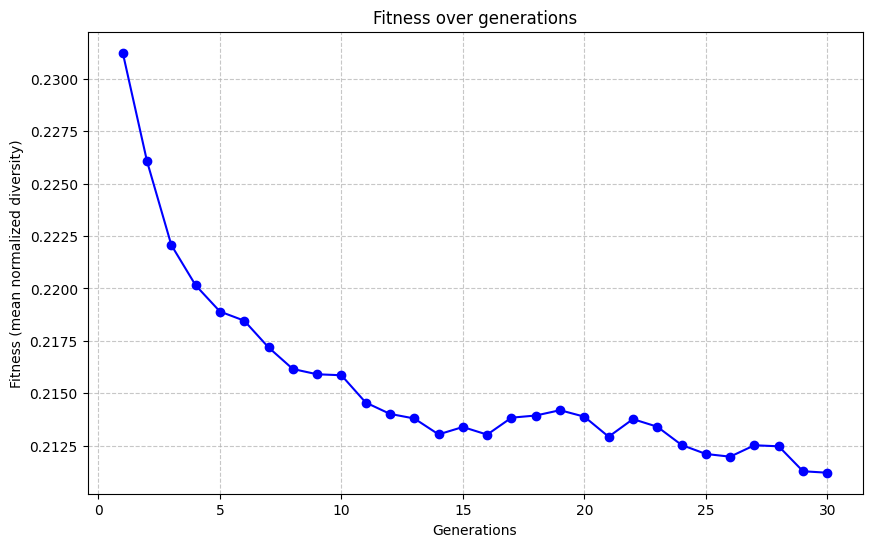

In [12]:
############################
import matplotlib.pyplot as plt

def plot_fitness_history():
    if not global_fitness_history:
        print("No fitness recorded for plotting")
        return

    generations = range(1, len(global_fitness_history) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        generations, 
        global_fitness_history, 
        marker='o', 
        linestyle='-', 
        color='blue'
    )
    plt.title('Fitness over generations')
    plt.xlabel('Generations')
    plt.ylabel('Fitness (mean normalized diversity)') 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_fitness_history()